In [1]:
#Importação de bibliotetcas 
#!pip install xgboost   #comando utilizado na primeira execução
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, ExtraTreesClassifier, AdaBoostClassifier 
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.pipeline import Pipeline

In [2]:
#Leitura do dataset
dataset_path = r'C:\Users\mateu\Desktop\Estudos\Femass\TCC\Dataset\twitter_human_bots_dataset.csv'
twitter_accounts_df: pd.DataFrame = pd.read_csv(dataset_path, index_col=0)

#Exibicao do dataset
print(f"Dataset columns: {twitter_accounts_df.columns}")
twitter_accounts_df.head()

Dataset columns: Index(['created_at', 'default_profile', 'default_profile_image', 'description',
       'favourites_count', 'followers_count', 'friends_count', 'geo_enabled',
       'id', 'lang', 'location', 'profile_background_image_url',
       'profile_image_url', 'screen_name', 'statuses_count', 'verified',
       'average_tweets_per_day', 'account_age_days', 'account_type'],
      dtype='object')


,created_at,default_profile,default_profile_image,description,favourites_count,followers_count,friends_count,geo_enabled,id,lang,location,profile_background_image_url,profile_image_url,screen_name,statuses_count,verified,average_tweets_per_day,account_age_days,account_type
0,2016-10-15 21:32:11,False,False,"Blame @xaiax, Inspired by @MakingInvisible, us...",4,1589,4,False,787405734442958848,en,unknown,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/7874121826...,best_in_dumbest,11041,False,7.870,1403,bot
1,2016-11-09 05:01:30,False,False,Photographing the American West since 1980. I ...,536,860,880,False,796216118331310080,en,Estados Unidos,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/8023296328...,CJRubinPhoto,252,False,0.183,1379,human
2,2017-06-17 05:34:27,False,False,Scruffy looking nerf herder and @twitch broadc...,3307,172,594,True,875949740503859204,en,"Los Angeles, CA",http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1278890453...,SVGEGENT,1001,False,0.864,1159,human
3,2016-07-21 13:32:25,True,False,Wife.Godmother.Friend.Feline Fanatic! Assistan...,8433,517,633,True,756119643622735875,en,"Birmingham, AL",NaN,http://pbs.twimg.com/profile_images/1284884924...,TinkerVHELPK5,1324,False,0.889,1489,human
4,2012-01-15 16:32:35,False,False,Loan coach at @mancity & Aspiring DJ,88,753678,116,True,464781334,en,"England, United Kingdom",http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/9952566258...,JoleonLescott,4202,True,1.339,3138,human


In [3]:
#Verificacao de valores vazios na base de dados
missing_data = {col: twitter_accounts_df[col].isna().sum() for col in twitter_accounts_df.columns}
missing_df = pd.DataFrame(list(missing_data.items()), columns=['Column', 'Missing Values'])
print(missing_df)

                          Column  Missing Values
0                     created_at               0
1                default_profile               0
2          default_profile_image               0
3                    description            7257
4               favourites_count               0
5                followers_count               0
6                  friends_count               0
7                    geo_enabled               0
8                             id               0
9                           lang            7957
10                      location               4
11  profile_background_image_url            4499
12             profile_image_url               1
13                   screen_name               0
14                statuses_count               0
15                      verified               0
16        average_tweets_per_day               0
17              account_age_days               0
18                  account_type               0


In [4]:
#Pre Processamento

# Transformacao de colunas booleanas em 0 e 1
bool_columns = ['default_profile', 'default_profile_image', 'geo_enabled', 'verified']
for col in bool_columns:
    if col in twitter_accounts_df.columns:
        twitter_accounts_df[col] = twitter_accounts_df[col].astype(int)

#Discretização dos atributos descrption e lang, transformando em booleanos
twitter_accounts_df['has_description'] = twitter_accounts_df['description'].apply(lambda x: 1 if pd.notna(x) and str(x).strip() != '' else 0)
twitter_accounts_df['has_lang'] = twitter_accounts_df['lang'].apply(lambda x: 1 if pd.notna(x) and str(x).strip() != '' else 0)

# Transformação de dados faltantes em location
twitter_accounts_df.fillna({'location': 'unknown'}, inplace=True)

#Conversão de created_at para datetime e determinação de tempo de conta (account_age_days)
twitter_accounts_df['created_at'] = pd.to_datetime(twitter_accounts_df['created_at'])
twitter_accounts_df['account_age_days'] = (pd.Timestamp.now() - twitter_accounts_df['created_at']).dt.days

# Remoção de colunas não utilizadas
drop_cols = ['created_at','lang', 'statuses_count', 'id', 'screen_name', 'profile_image_url', 'profile_background_image_url','description']
twitter_accounts_df.drop(columns=drop_cols, inplace=True, errors='ignore')

#Conversão da classe human para humano
twitter_accounts_df['account_type'] = twitter_accounts_df['account_type'].map({'human': 'humano','bot':'bot'})

In [5]:
#Verificação das transformações nos atributos
twitter_accounts_df.head(100)

,default_profile,default_profile_image,favourites_count,followers_count,friends_count,geo_enabled,location,verified,average_tweets_per_day,account_age_days,account_type,has_description,has_lang
0,0,0,4,1589,4,0,unknown,0,7.870,3325,bot,1,1
1,0,0,536,860,880,0,Estados Unidos,0,0.183,3301,humano,1,1
2,0,0,3307,172,594,1,"Los Angeles, CA",0,0.864,3081,humano,1,1
3,1,0,8433,517,633,1,"Birmingham, AL",0,0.889,3412,humano,1,1
4,0,0,88,753678,116,1,"England, United Kingdom",1,1.339,5061,humano,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,1115,2015401,14905,0,España,1,103.295,6138,bot,1,1
96,1,0,2747,223,624,0,"Austintown, Ohio",0,1.338,5994,bot,1,1
97,1,0,114220,492,856,1,"Fox Chase, PA • Chandler, AZ",0,40.064,4596,humano,1,1
98,0,0,344286,1662199,924,1,Wyoming and Montana,1,14.649,7073,humano,1,1


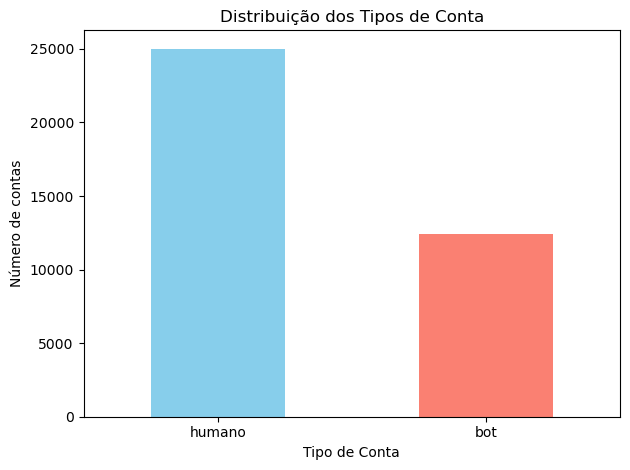

In [6]:
# Gráficos de colunas p/ verificar distribuição das classes
account_counts = twitter_accounts_df['account_type'].value_counts()
account_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribuição dos Tipos de Conta')
plt.xlabel('Tipo de Conta')
plt.ylabel('Número de contas')
plt.xticks(rotation=0)
plt.tight_layout()

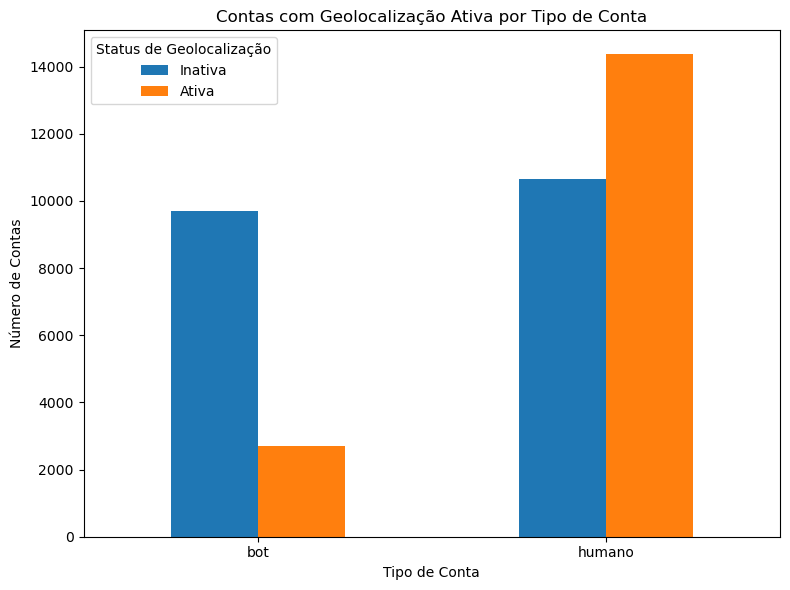

In [7]:
#Agrupamento por Tipo de Conta e Geolocalização 
geo_counts = twitter_accounts_df.groupby('account_type')['geo_enabled'].value_counts().unstack().fillna(0)
geo_counts.columns = ['geo_disabled', 'geo_enabled']

#Criação de gráfico de colunas com agrupamento por Geolocalização
geo_counts.plot(kind='bar', figsize=(8, 6))
plt.title('Contas com Geolocalização Ativa por Tipo de Conta')
plt.xlabel('Tipo de Conta')
plt.ylabel('Número de Contas')
plt.xticks(rotation=0)
plt.legend(title='Status de Geolocalização', labels=['Inativa', 'Ativa'])
plt.tight_layout()

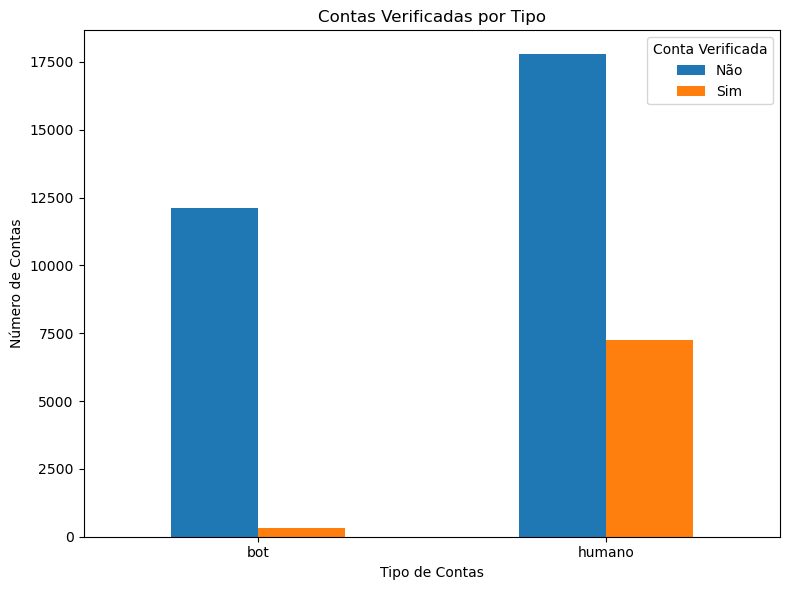

In [8]:
#Agrupamento por Tipo de Conta e Verificação de Conta 
verified_counts = twitter_accounts_df.groupby('account_type')['verified'].value_counts().unstack().fillna(0)
verified_counts.columns = ['not_verified', 'verified']

#Criação de gráfico de colunas com agrupamento por Verificação de Conta
verified_counts.plot(kind='bar', figsize=(8, 6))
plt.title('Contas Verificadas por Tipo')
plt.xlabel('Tipo de Contas')
plt.ylabel('Número de Contas')
plt.xticks(rotation=0)
plt.legend(title='Conta Verificada', labels=['Não', 'Sim'])
plt.tight_layout()

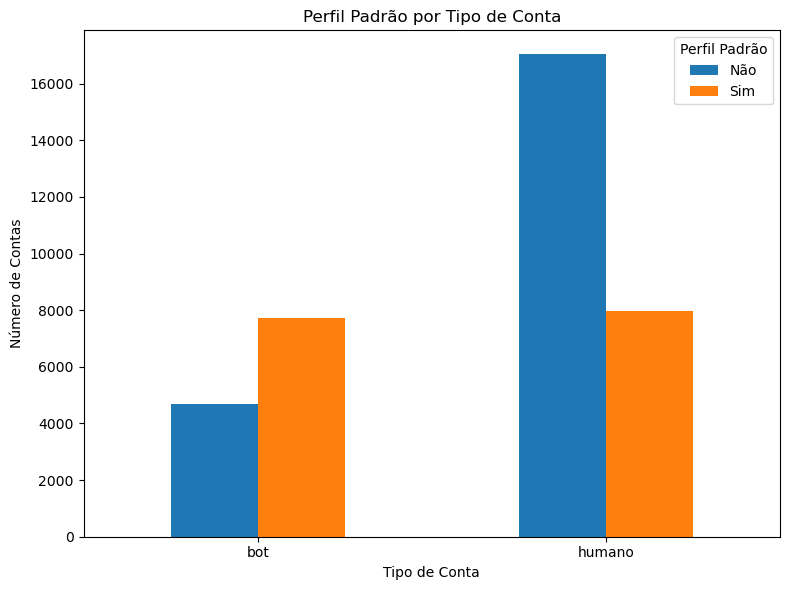

In [9]:
#Agrupamento por Tipo de Conta e Perfil Padrão 
counts = twitter_accounts_df.groupby('account_type')['default_profile'].value_counts().unstack().fillna(0)
counts.columns = ['not_default_profile', 'default_profile']

#Criação de gráfico de colunas com agrupamento por Perfil Padrão
counts.plot(kind='bar', figsize=(8, 6))
plt.title('Perfil Padrão por Tipo de Conta')
plt.xlabel('Tipo de Conta')
plt.ylabel('Número de Contas')
plt.xticks(rotation=0)
plt.legend(title='Perfil Padrão', labels=['Não', 'Sim'])
plt.tight_layout()
plt.show()

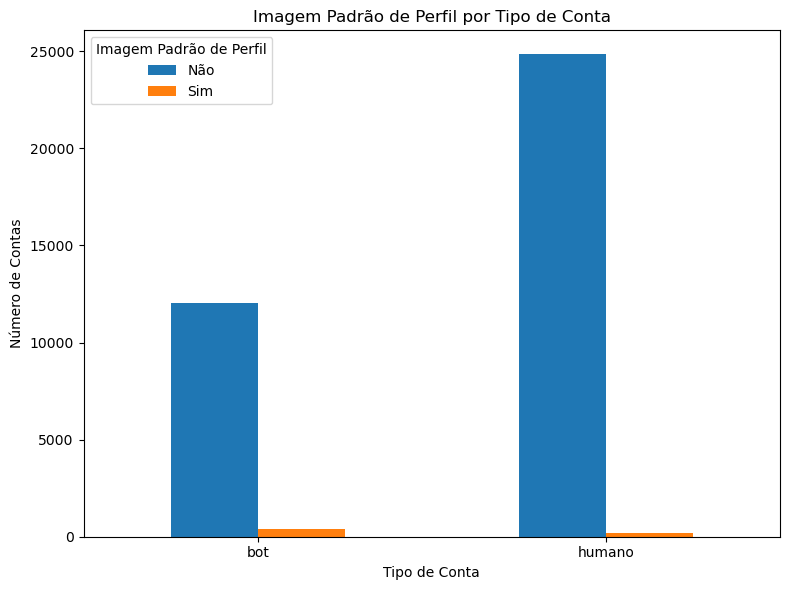

In [10]:
#Agrupamento por Tipo de Conta e Imagem Padrão de Perfil
counts = twitter_accounts_df.groupby('account_type')['default_profile_image'].value_counts().unstack().fillna(0)
counts.columns = ['not_default_profile_image', 'default_profile_image']

#Criação de gráfico de colunas com agrupamento por Imagem Padrão de Perfil
counts.plot(kind='bar', figsize=(8, 6))
plt.title('Imagem Padrão de Perfil por Tipo de Conta')
plt.xlabel('Tipo de Conta')
plt.ylabel('Número de Contas')
plt.xticks(rotation=0)
plt.legend(title='Imagem Padrão de Perfil', labels=['Não', 'Sim'])
plt.tight_layout()
plt.show()

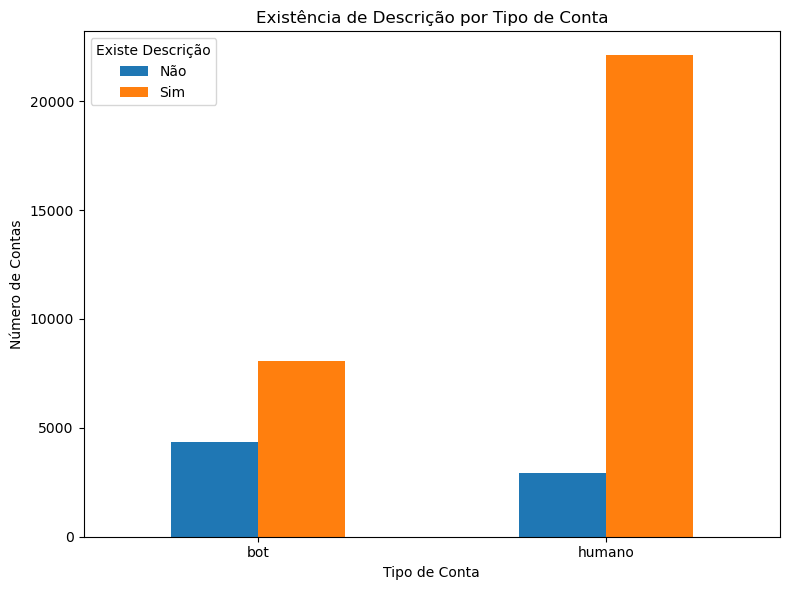

In [11]:
#Agrupamento por Tipo de Conta e Existência de Descrição
counts = twitter_accounts_df.groupby('account_type')['has_description'].value_counts().unstack().fillna(0)
counts.columns = ['no_description', 'has_description']

#Criação de gráfico de colunas com agrupamento por Existência de Descrição
counts.plot(kind='bar', figsize=(8, 6))
plt.title('Existência de Descrição por Tipo de Conta')
plt.xlabel('Tipo de Conta')
plt.ylabel('Número de Contas')
plt.xticks(rotation=0)
plt.legend(title='Existe Descrição', labels=['Não', 'Sim'])
plt.tight_layout()
plt.show()

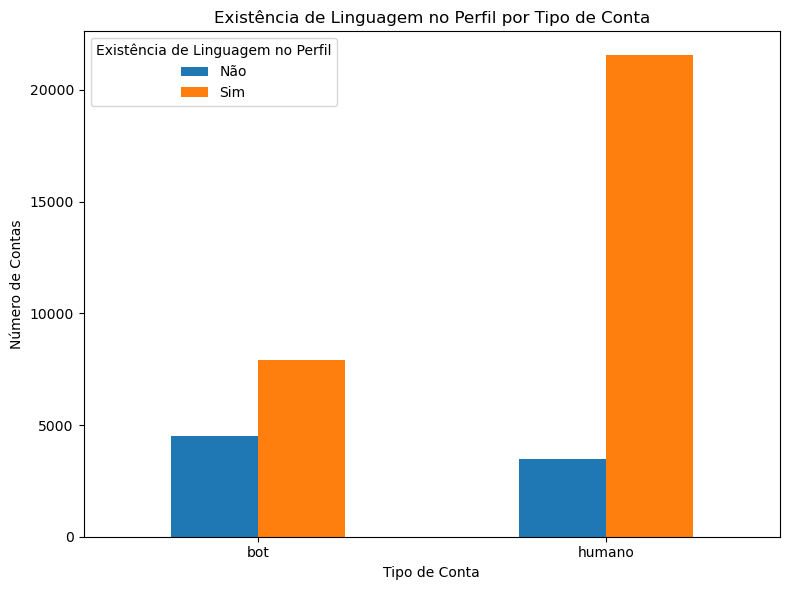

In [12]:
#Agrupamento por Tipo de Conta e Existência de Linguagem no Perfil 
counts = twitter_accounts_df.groupby('account_type')['has_lang'].value_counts().unstack().fillna(0)
counts.columns = ['no_lang', 'has_lang']

#Criação de gráfico de colunas com agrupamento por Existência de Linguagem no Perfil
counts.plot(kind='bar', figsize=(8, 6))
plt.title('Existência de Linguagem no Perfil por Tipo de Conta')
plt.xlabel('Tipo de Conta')
plt.ylabel('Número de Contas')
plt.xticks(rotation=0)
plt.legend(title='Existência de Linguagem no Perfil', labels=['Não', 'Sim'])
plt.tight_layout()
plt.show()

In [13]:
# Métricas Numéricas para Análise, agrupadas por tipo de conta
metrics = ['favourites_count', 'followers_count', 'friends_count','average_tweets_per_day','account_age_days']
for metric in metrics:
    print(f"\n📌 Statistics for '{metric}' by Account Type:\n")
    summary = twitter_accounts_df.groupby('account_type')[metric].describe()
    print(summary)


📌 Statistics for 'favourites_count' by Account Type:

                count          mean           std  min    25%     50%  \
account_type                                                            
bot           12425.0   4483.136740  23913.709073  0.0  140.0  1131.0   
humano        25013.0  16186.048455  37322.654404  0.0  649.0  3649.0   

                  75%       max  
account_type                     
bot            2231.0  839929.0  
humano        14955.0  885123.0  

📌 Statistics for 'followers_count' by Account Type:

                count           mean           std  min    25%     50%  \
account_type                                                             
bot           12425.0   73500.273803  1.066970e+06  0.0    8.0    25.0   
humano        25013.0  517747.512254  2.916633e+06  0.0  184.0  1046.0   

                  75%          max  
account_type                        
bot             193.0   49557935.0  
humano        72246.0  121641473.0  

📌 Statistics for

C:\Users\mateu\AppData\Local\Temp\ipykernel_30840\1480742810.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=location_counts.values, y=location_counts.index, palette='viridis')


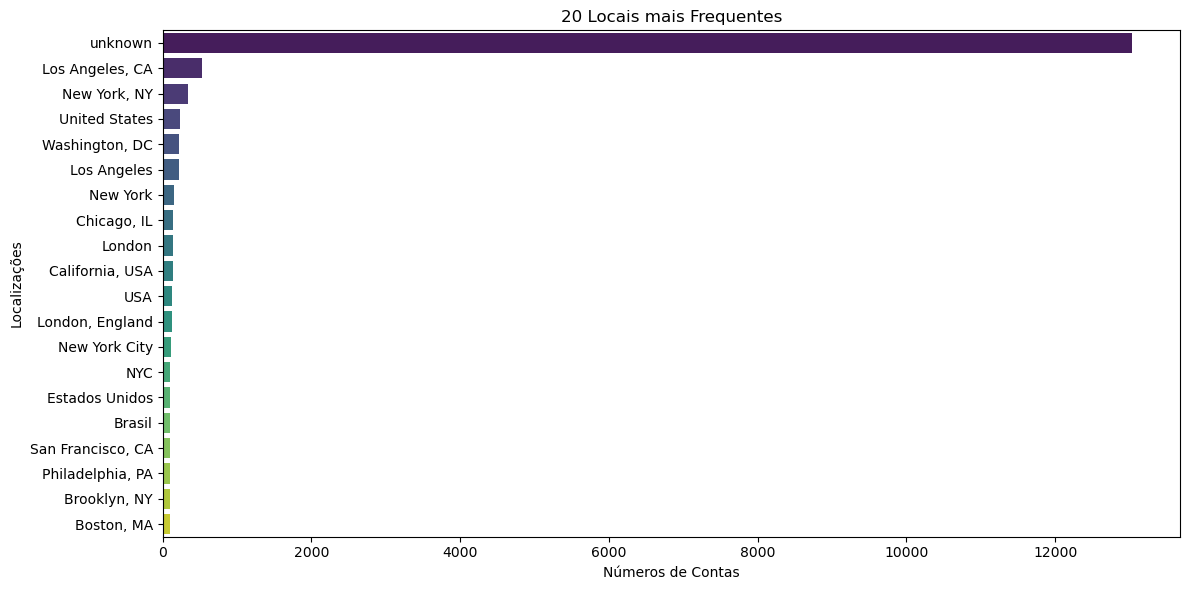

In [14]:
# Count the most common locations (excluding 'unknown' or empty)
location_counts = twitter_accounts_df['location'].value_counts().head(20)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=location_counts.values, y=location_counts.index, palette='viridis')
plt.title('20 Locais mais Frequentes')
plt.xlabel('Números de Contas')
plt.ylabel('Localizações')
plt.tight_layout()
plt.show()


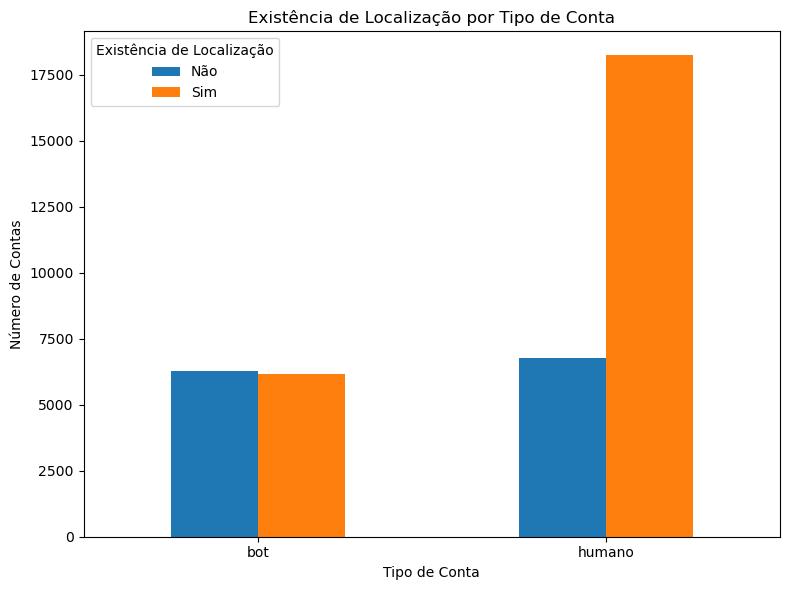

In [15]:
# Cria uma nova coluna: 1 se 'location' estiver preenchida, 0 se estiver vazia ou nula
twitter_accounts_df['has_location'] = twitter_accounts_df['location'].apply(
    lambda x: 1 if pd.notna(x) and str(x).strip() != '' and str(x).strip().lower() != 'unknown' else 0
)

# Agrupa por tipo de conta e valor booleano
counts = twitter_accounts_df.groupby('account_type')['has_location'].value_counts().unstack().fillna(0)
counts.columns = ['no_location', 'has_location']

#Remover coluna location
twitter_accounts_df.drop(columns=['location'], inplace=True)

# Plota gráfico
counts.plot(kind='bar', figsize=(8, 6))
plt.title('Existência de Localização por Tipo de Conta')
plt.xlabel('Tipo de Conta')
plt.ylabel('Número de Contas')
plt.xticks(rotation=0)
plt.legend(title='Existência de Localização', labels=['Não', 'Sim'])
plt.tight_layout()
plt.show()

In [16]:
# Substitui os valores de texto por números diretamente na coluna
twitter_accounts_df['account_type'] = twitter_accounts_df['account_type'].map({'humano': 0, 'bot': 1})

In [17]:
#Divisão em dados de treino e teste, utilizando estratificação
from sklearn.model_selection import train_test_split
X = twitter_accounts_df.drop('account_type', axis=1)
y = twitter_accounts_df['account_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

🔍 Random Forest Best Params: {'class_weight': 'balanced', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}

=== 🧠 TRAINING SET PERFORMANCE ===
📋 Training Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     20010
           1       0.98      0.97      0.97      9940

    accuracy                           0.98     29950
   macro avg       0.98      0.98      0.98     29950
weighted avg       0.98      0.98      0.98     29950



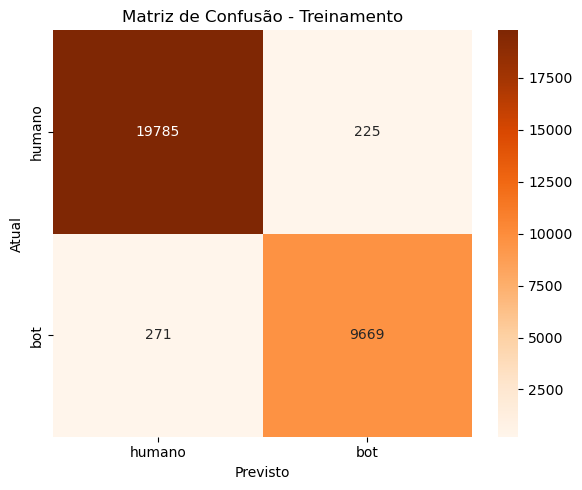

🎯 Training ROC-AUC Score: 0.9989


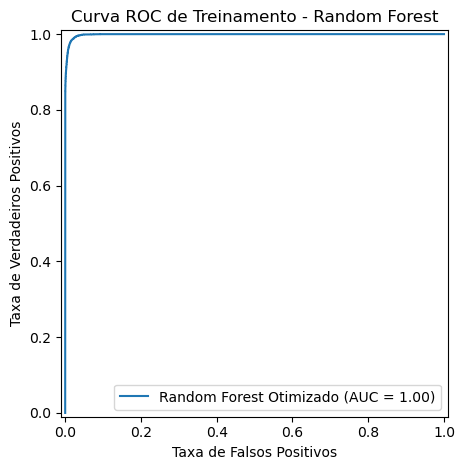


=== 🧪 TEST SET PERFORMANCE ===
📋 Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      5003
           1       0.85      0.78      0.81      2485

    accuracy                           0.88      7488
   macro avg       0.87      0.85      0.86      7488
weighted avg       0.88      0.88      0.88      7488



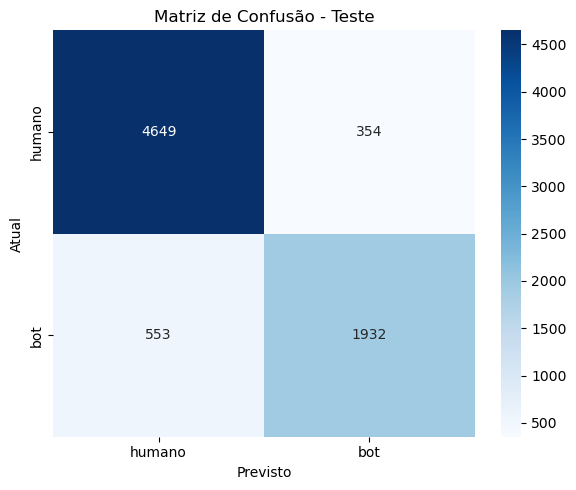

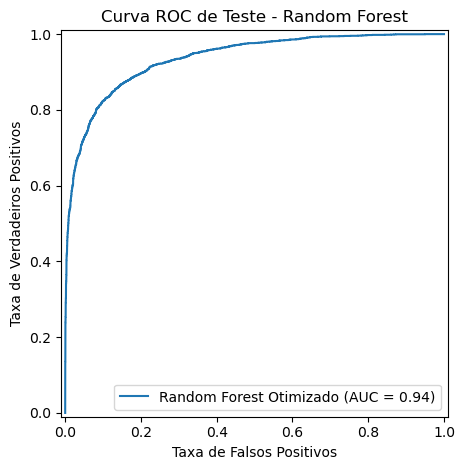

🎯 Test ROC-AUC Score: 0.9361


In [18]:
#Algoritmo Random-Forest

# Define dos Hiperparâmetros
rf_params = {
    'n_estimators': [100, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced']
}

rf_model = RandomForestClassifier()
rf_grid = GridSearchCV(rf_model, rf_params, cv=5, scoring='roc_auc', n_jobs=-1)
rf_grid.fit(X_train, y_train)

print("🔍 Random Forest Best Params:", rf_grid.best_params_)
rf_best = rf_grid.best_estimator_

class_labels = ['humano', 'bot']
# ======================================================================
# 💡 Dados de Treinamento
# ======================================================================
print("\n=== 🧠 TRAINING SET PERFORMANCE ===")

# 1. Previsão das Classes - Treinamento
y_pred_train = rf_best.predict(X_train)
y_proba_train = rf_best.predict_proba(X_train)[:, 1]

# 2. Determinação de Métricas - Treinamento
print("📋 Training Classification Report:")
print(classification_report(y_train, y_pred_train))

# 3. Matriz de Confusão - Treinamento
conf_matrix_train = confusion_matrix(y_train, y_pred_train)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Oranges',xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matriz de Confusão - Treinamento')
plt.xlabel('Previsto')
plt.ylabel('Atual')
plt.tight_layout()
plt.show()

# 4. ROC-AUC Score - Treinamento
roc_auc_train = roc_auc_score(y_train, y_proba_train)
print(f"🎯 Training ROC-AUC Score: {roc_auc_train:.4f}")

# 5. Curva ROC - Treinamento
RocCurveDisplay.from_estimator(rf_best, X_train, y_train, name='Random Forest Otimizado')
plt.title('Curva ROC de Treinamento - Random Forest')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.tight_layout()
plt.show()

print("==========================================================")
# ======================================================================
# 🧪 Dados de Teste
# ======================================================================
print("\n=== 🧪 TEST SET PERFORMANCE ===")

# 1. Predição das Classes - Teste
y_pred = rf_best.predict(X_test)
y_proba = rf_best.predict_proba(X_test)[:, 1]

# 2. Determinação de Métricas - Teste
print("📋 Classification Report:")
print(classification_report(y_test, y_pred))

# 3. Matriz de Confusão - Teste
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matriz de Confusão - Teste')
plt.xlabel('Previsto')
plt.ylabel('Atual')
plt.tight_layout()
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(rf_best, X_test, y_test, name='Random Forest Otimizado')
plt.title('Curva ROC de Teste - Random Forest')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.tight_layout()
plt.show()

# ROC-AUC Score
roc_auc_test = roc_auc_score(y_test, y_proba)
print(f"🎯 Test ROC-AUC Score: {roc_auc_test:.4f}")

C:\Users\mateu\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:22:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔍 XGBoost Best Params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'scale_pos_weight': 1, 'subsample': 0.8}

=== 🧠 TRAINING SET PERFORMANCE ===
📋 Training Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     20010
           1       0.91      0.82      0.86      9940

    accuracy                           0.91     29950
   macro avg       0.91      0.89      0.90     29950
weighted avg       0.91      0.91      0.91     29950



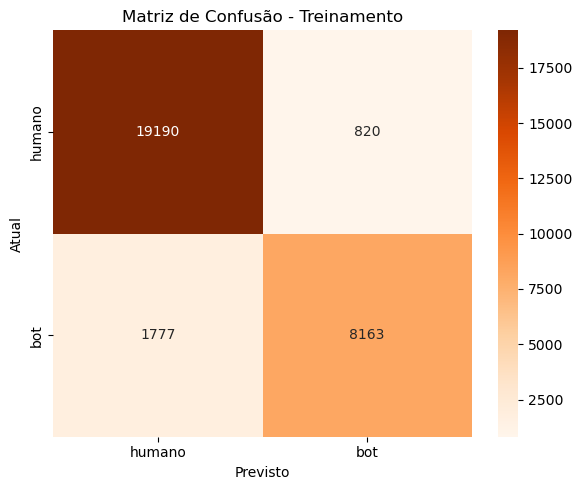

🎯 Training ROC-AUC Score: 0.9686


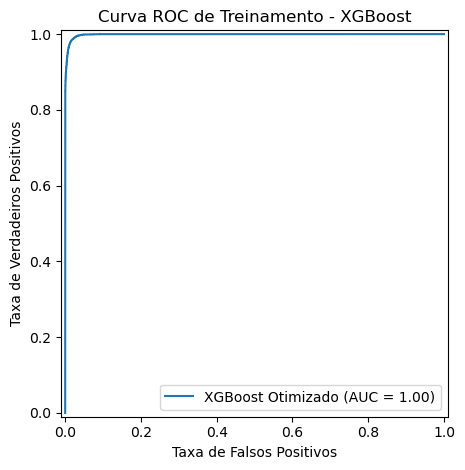


=== 🧪 TEST SET PERFORMANCE ===
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      5003
           1       0.86      0.77      0.81      2485

    accuracy                           0.88      7488
   macro avg       0.87      0.85      0.86      7488
weighted avg       0.88      0.88      0.88      7488

XGBoost ROC-AUC Score: 0.9375349036051206
ROC-AUC Score: 0.9375349036051206


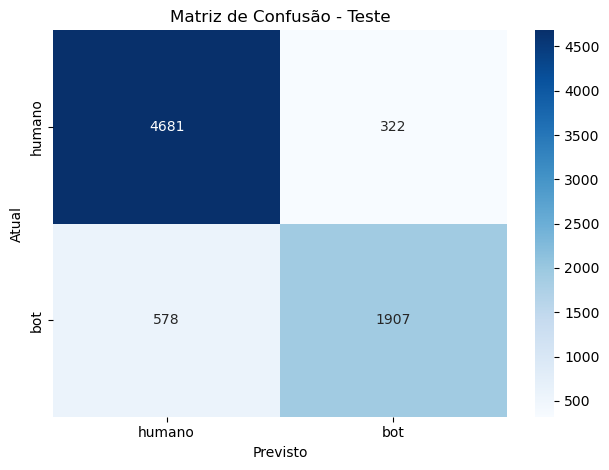

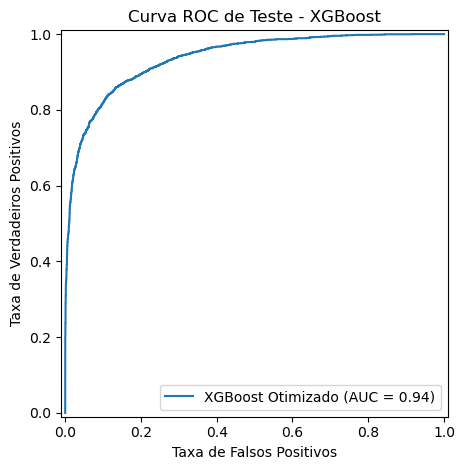

In [19]:
#Algoritmo XGBoost

# Define dos Hiperparâmetros
xgb_params = {
    'n_estimators': [100, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1, 3]
}

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=5, scoring='roc_auc', n_jobs=-1)
xgb_grid.fit(X_train, y_train)

print("🔍 XGBoost Best Params:", xgb_grid.best_params_)
xgb_best = xgb_grid.best_estimator_

class_labels = ['humano', 'bot']
# ======================================================================
# 💡 Dados de Treinamento
# ======================================================================
print("\n=== 🧠 TRAINING SET PERFORMANCE ===")

# 1. Previsão das Classes - Treinamento
y_pred_train = xgb_best.predict(X_train)
y_proba_train = xgb_best.predict_proba(X_train)[:, 1]

# 2. Determinação de Métricas - Treinamento
print("📋 Training Classification Report:")
print(classification_report(y_train, y_pred_train))

# 3. Matriz de Confusão - Treinamento
conf_matrix_train = confusion_matrix(y_train, y_pred_train)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Oranges',xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matriz de Confusão - Treinamento')
plt.xlabel('Previsto')
plt.ylabel('Atual')
plt.tight_layout()
plt.show()

# 4. ROC-AUC Score - Treinamento
roc_auc_train = roc_auc_score(y_train, y_proba_train)
print(f"🎯 Training ROC-AUC Score: {roc_auc_train:.4f}")

# 5. Curva ROC - Treinamento
RocCurveDisplay.from_estimator(rf_best, X_train, y_train, name='XGBoost Otimizado')
plt.title('Curva ROC de Treinamento - XGBoost')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.tight_layout()
plt.show()

print("==========================================================")
# ======================================================================
# 🧪 Dados de Teste
# ======================================================================
print("\n=== 🧪 TEST SET PERFORMANCE ===")

# 1. Previsão das Classes - Teste
y_pred_xgb = xgb_best.predict(X_test)
y_proba_xgb = xgb_best.predict_proba(X_test)[:, 1]

# 2. Determinação de Métricas - Teste
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("XGBoost ROC-AUC Score:", roc_auc_score(y_test, y_proba_xgb))

# 3. Matriz de Confusão - Teste
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matriz de Confusão - Teste')
plt.xlabel('Previsto')
plt.ylabel('Atual')
plt.tight_layout()

# ROC Curve
RocCurveDisplay.from_estimator(xgb_best, X_test, y_test, name='XGBoost Otimizado')
plt.title('Curva ROC de Teste - XGBoost')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.tight_layout() 

# ROC-AUC Score
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_xgb))

C:\Users\mateu\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


🔍 AdaBoost Best Params: {'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 200}

=== 🧠 TRAINING SET PERFORMANCE ===
📋 Training Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89     20010
           1       0.80      0.73      0.76      9940

    accuracy                           0.85     29950
   macro avg       0.84      0.82      0.83     29950
weighted avg       0.85      0.85      0.85     29950



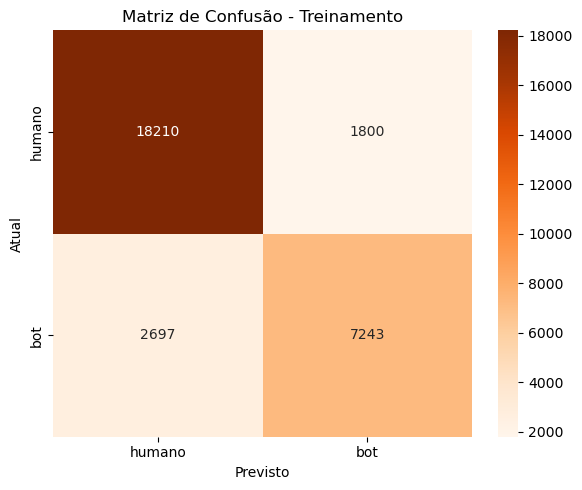

🎯 Training ROC-AUC Score: 0.9117


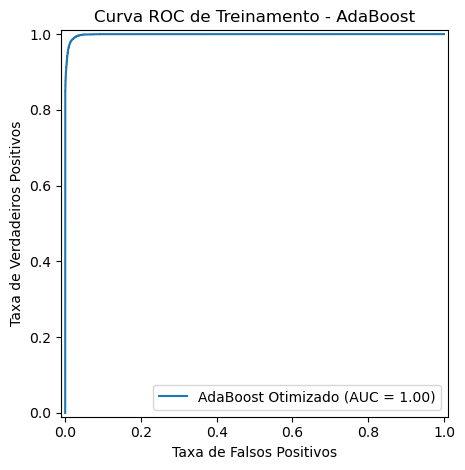


=== 🧪 TEST SET PERFORMANCE ===
AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      5003
           1       0.79      0.73      0.76      2485

    accuracy                           0.85      7488
   macro avg       0.83      0.82      0.82      7488
weighted avg       0.84      0.85      0.84      7488

AdaBoost ROC-AUC Score: 0.9048720063736406


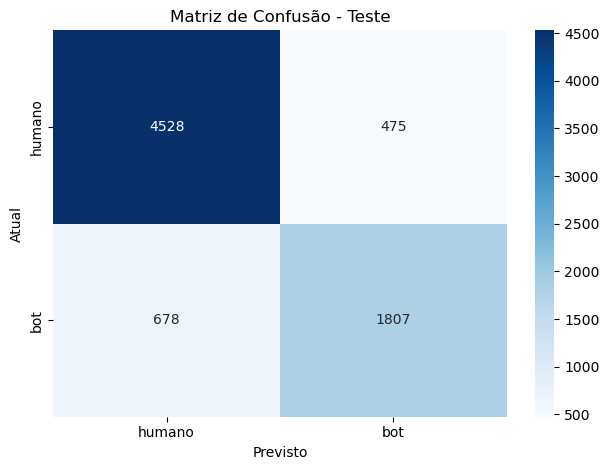

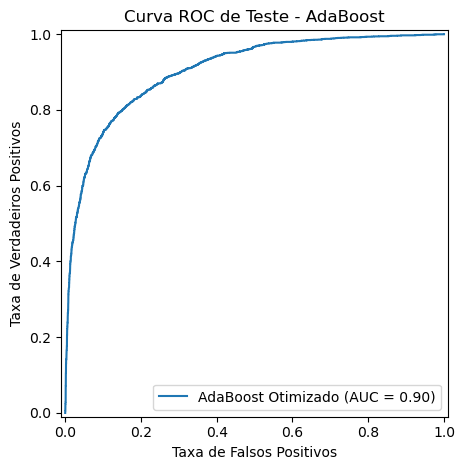

ROC-AUC Score: 0.9048720063736406


In [21]:
#Algoritmo AdaBoost

# Define dos Hiperparâmetros
ada_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'algorithm': ['SAMME', 'SAMME.R']
}

ada_model = AdaBoostClassifier()
ada_grid = GridSearchCV(ada_model, ada_params, cv=5, scoring='roc_auc', n_jobs=-1)
ada_grid.fit(X_train, y_train)

print("🔍 AdaBoost Best Params:", ada_grid.best_params_)
ada_best = ada_grid.best_estimator_

class_labels = ['humano', 'bot']
# ======================================================================
# 💡 Dados de Treinamento
# ======================================================================
print("\n=== 🧠 TRAINING SET PERFORMANCE ===")

# 1. Previsão das Classes - Treinamento
y_pred_train = ada_best.predict(X_train)
y_proba_train = ada_best.predict_proba(X_train)[:, 1]

# 2. Determinação de Métricas - Treinamento
print("📋 Training Classification Report:")
print(classification_report(y_train, y_pred_train))

# 3. Matriz de Confusão - Treinamento
conf_matrix_train = confusion_matrix(y_train, y_pred_train)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Oranges',xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matriz de Confusão - Treinamento')
plt.xlabel('Previsto')
plt.ylabel('Atual')
plt.tight_layout()
plt.show()

# 4. ROC-AUC Score - Treinamento
roc_auc_train = roc_auc_score(y_train, y_proba_train)
print(f"🎯 Training ROC-AUC Score: {roc_auc_train:.4f}")

# 5. Curva ROC - Treinamento
# Note: Generating ROC Curve on train data is often less common, but included for completeness
RocCurveDisplay.from_estimator(rf_best, X_train, y_train, name='AdaBoost Otimizado')
plt.title('Curva ROC de Treinamento - AdaBoost')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.tight_layout()
plt.show()

print("==========================================================")
# ======================================================================
# 🧪 Dados de Teste
# ======================================================================
print("\n=== 🧪 TEST SET PERFORMANCE ===")

# 1. Previsão das Classes - Teste
y_pred_ada = ada_best.predict(X_test)
y_proba_ada = ada_best.predict_proba(X_test)[:, 1]

# 2. Determinação de Métricas - Teste
print("AdaBoost Classification Report:")
print(classification_report(y_test, y_pred_ada))
print("AdaBoost ROC-AUC Score:", roc_auc_score(y_test, y_proba_ada))

# 3. Matriz de Confusão - Teste
conf_matrix = confusion_matrix(y_test, y_pred_ada)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matriz de Confusão - Teste')
plt.xlabel('Previsto')
plt.ylabel('Atual')
plt.tight_layout()
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(ada_best, X_test, y_test, name='AdaBoost Otimizado')
plt.title('Curva ROC de Teste - AdaBoost')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.tight_layout()
plt.show()

# ROC-AUC Score
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_ada))


In [ ]:
#Algoritmo KNN

# Definição dos Hiperparâmetros
knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_model = KNeighborsClassifier()
knn_grid = GridSearchCV(knn_model, knn_params, cv=5, scoring='roc_auc', n_jobs=-1)
knn_grid.fit(X_train, y_train)

print("🔍 KNN Best Params:", knn_grid.best_params_)
knn_best = knn_grid.best_estimator_

class_labels = ['humano', 'bot']
# ======================================================================
# 💡 Dados de Treinamento
# ======================================================================
print("\n=== 🧠 TRAINING SET PERFORMANCE ===")

# 1. Previsão das Classes - Treinamento
y_pred_train = knn_best.predict(X_train)
y_proba_train = knn_best.predict_proba(X_train)[:, 1]

# 2. Determinação de Métricas - Treinamento
print("📋 Training Classification Report:")
print(classification_report(y_train, y_pred_train))

# 3. Matriz de Confusão - Treinamento
conf_matrix_train = confusion_matrix(y_train, y_pred_train)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Oranges',xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matriz de Confusão - Treinamento')
plt.xlabel('Previsto')
plt.ylabel('Atual')
plt.tight_layout()
plt.show()

# 4. ROC-AUC Score - Treinamento
roc_auc_train = roc_auc_score(y_train, y_proba_train)
print(f"🎯 Training ROC-AUC Score: {roc_auc_train:.4f}")

# 5. Curva ROC - Treinamento
RocCurveDisplay.from_estimator(rf_best, X_train, y_train, name='KNN Otimizado')
plt.title('Curva ROC de Treinamento - KNN')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.tight_layout()
plt.show()

print("==========================================================")
# ======================================================================
# 🧪 Dados de Teste
# ======================================================================
print("\n=== 🧪 TEST SET PERFORMANCE ===")

# 1. Previsão das Classes - Teste
y_pred_knn = knn_best.predict(X_test)
y_proba_knn = knn_best.predict_proba(X_test)[:, 1]

# 2. Determinação de Métricas - Teste
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))
print("KNN ROC-AUC Score:", roc_auc_score(y_test, y_proba_knn))

# 3. Matriz de Confusão - Teste
conf_matrix = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matriz de Confusão - Teste')
plt.xlabel('Previsto')
plt.ylabel('Atual')
plt.tight_layout()

# ROC Curve
RocCurveDisplay.from_estimator(knn_best, X_test, y_test, name='KNN Otimizado')
plt.title('Curva ROC de Teste - KNN')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.tight_layout()

# ROC-AUC Score
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_knn))

In [ ]:
#Método Combinado

#Definição dos Hiperparâmetros
base_ensemble = VotingClassifier(
    estimators=[
        ('rf', rf_best),
        ('xgb', xgb_best)
    ],
    voting='soft',
    n_jobs=1,  # Set n_jobs=1 for the base model, GridSearch will handle parallelization
)

print("Tuning Ensemble Weights with GridSearchCV...")
ensemble_params = {
    'weights': [
        [0.5, 0.5], # Equal weights
        [0.6, 0.4],
        [0.4, 0.6],
        [0.7, 0.3],
        [0.3, 0.7]
    ]
}

ensemble_grid = GridSearchCV(
    base_ensemble,
    ensemble_params,
    cv=5,                 
    scoring='roc_auc',
    n_jobs=-1           
)

ensemble_grid.fit(X_train, y_train)

print("\n🔍 Ensemble Best Params (Weights):", ensemble_grid.best_params_)
ensemble_model = ensemble_grid.best_estimator_
print("Ensemble Fit Complete.")

class_labels = ['humano', 'bot']
# ----------------------------------------------------------------------
# 💡 Dados de Treinamento
# ----------------------------------------------------------------------
print("\n=== 🧠 OPTIMIZED ENSEMBLE TRAINING SET PERFORMANCE ===")

# 1. Previsão das Classes - Treinamento
y_pred_train_ensemble = ensemble_model.predict(X_train)
y_proba_train_ensemble = ensemble_model.predict_proba(X_train)[:, 1]

# 2. Determinação de Métricas - Treinamento
print("📋 Training Classification Report:")
print(classification_report(y_train, y_pred_train_ensemble))

# 3. Matriz de Confusão - Treinamento
conf_matrix_train = confusion_matrix(y_train, y_pred_train_ensemble)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Oranges',xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matriz de Confusão - Treinamento')
plt.xlabel('Previsto')
plt.ylabel('Atual')
plt.tight_layout()
plt.show()

# 4. ROC-AUC Score - Treinamento
roc_auc_train_ensemble = roc_auc_score(y_train, y_proba_train_ensemble)
print(f"🎯 Training ROC-AUC Score: {roc_auc_train_ensemble:.4f}")

print("==========================================================")
# ----------------------------------------------------------------------
# 🧪 Dados de Teste
# ----------------------------------------------------------------------
print("\n=== 🚀 OPTIMIZED ENSEMBLE TEST SET PERFORMANCE ===")

# 1. Previsão das Classes - Teste
y_pred_ensemble = ensemble_model.predict(X_test)
y_proba_ensemble = ensemble_model.predict_proba(X_test)[:, 1]

# 2. Determinação de Métricas - Teste
print("📋 Ensemble Classification Report:")
print(classification_report(y_test, y_pred_ensemble))

# 3. Matriz de Confusão - Teste
conf_matrix_ensemble = confusion_matrix(y_test, y_pred_ensemble)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_ensemble, annot=True, fmt='d', cmap='Blues',xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matriz de Confusão - Teste')
plt.xlabel('Previsto')
plt.ylabel('Atual')
plt.tight_layout()
plt.show()

# 3. ROC-AUC Score
roc_auc_ensemble = roc_auc_score(y_test, y_proba_ensemble)
print(f"🎯 Ensemble ROC-AUC Score: {roc_auc_ensemble:.4f}")

# 5. ROC Curve (Test)
RocCurveDisplay.from_estimator(ensemble_model, X_test, y_test, name='Método Combinado Otimizado')
plt.title('Curva ROC de Teste - Método Combinado')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.tight_layout()
plt.tight_layout()
plt.show()